In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import tifffile as tif

# local
from synapse_features import get_one_volume
from cohort import get_cohort, get_imagepair, get_raw_coord
from build_features import get_percentiles, get_cdf, get_reduced_cdf, snr

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Estimate the size of synapse
Fitting 3D gaussian to classified synapses ( results used in synspy.analyze.util ), 40% of synapses are in the middle 3x3 block on the central slice, and 27% in the same area one slice up and down ( total 96% ). After an inspection by eye, sometimes there appears to be a small shift ( ~1 pixel ) for where the synapse centroid appears on the z slices adjacent to the central slice. We expect that intensity distribution on the central slice was the main reason to classify the centroid as a synapse/not in human classification. Thus, we estimate the SBR from the 5x5 pixel area on the central z slice. 

## Get intensity distribution around synapses
For all the synapses in the cohort, we will crop a 5x5 pixel area around each synapse and get the min&max Intensity and intensity percentiles: min, 5, 10, 15, 20, ..., 85, 90, 95, max . We will use 10th percentile as the intensity of the local background. And will define the SBR as the ratio of the max Intensity in the 5x5 pixel area to the 10th percentile. 


###  Load classified synapses from cohort
First import the information from the cohort csv. This will create a dictinary syn with the following keys: 

|-----[**study_id**] : list of all the fish IDs

|----------[**'lost', 'gain', 'uncB', 'uncA'**]

|---------------[**'xyz', 'int_core', 'int_vcn', 'xyz_pix', 'raw_xyz', 'raw_xyz_pix'**]



**To import cohort data:**

This code loads cohort data from a csv that has been pulled from the database. 

To run this code you will need 2 files: a csv with the synapse positions and intensity for each study and an "key" excel file that asigns each study to a behavioral group (Learner, Nonlearner, CS NS US control). The files are assigned to Dataset: 1-1EWW with the following RIDs:
* 1-1S94 (1-1EWW_1-0YEY_SynapsePositions.csv) 

https://synapse.isrd.isi.edu/chaise/record/#1/Synapse:File/RID=1-1S94

* 1-1S90 (1-1EWW_CohortKey)

https://synapse.isrd.isi.edu/chaise/record/#1/Synapse:File/RID=1-1S90

You will also need Image and Image Pair Study tables from the database to look up image alighnments. You can get them by navigating to the main page (https://synapse.isrd.isi.edu/), in the **Overview of Synapse Data Model** click Image and ImagePair and then in the top right corner **Export --> Search results (csv)** and save csv files for both tables. Provide their location in **img_table** and **ips_table**.

SynapsePositions are in microns, and the **resolution** of the raw image files should be provided to go from microns to pixels. 

SynapsePositions are in the template space ( registered to the template fish). The registration is done by first aligning the timepoint 2 image to the timepoint 1 and then aligning both to the template image. We need to undo these transformations to get the coordinates in the raw images.

In [3]:
csv_filename = 'D:/Code/repos/synapse-redistribution/get_data/data/' \
                   '1-1EWW_1-0YEY_SynapsePositions.csv '
cohort_key = 'D:/Code/repos/synapse-redistribution/get_data/data/1-1EWW_CohortKey.csv'

resolution = [0.26,0.26,0.4]
syn, stu = get_cohort(csv_filename, cohort_key, img_resolution = resolution)

# to go to the raw coordinates from the registered space 
# we need alignmet from Image to template ('Alignment')
img_table = "D:/Code/repos/psd95_segmentation/data/raw/Image_db.csv"
ips_table = "D:/Code/repos/psd95_segmentation/data/raw/ImagePairStudy_db.csv"

# undo all alignment 
syn = get_raw_coord(syn, img_table, ips_table,resolution)

Doing LR
Doing NL
Doing NS
Doing US
Doing CS


### Verify the cropped areas look correctly
Have a look at the cropped synapses : this will show if the transformations vere properly cancelled out and will give you some intuition on intensity distribution around the centroids.

This example shows crops for timepoint 2 (tp = 2) of fish '1-0CN2'

Volume shape :  (253, 2048, 2048)
Location :  [548. 766.  86.]


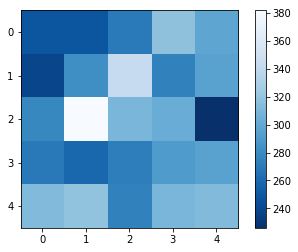

Location :  [421. 676.  88.]


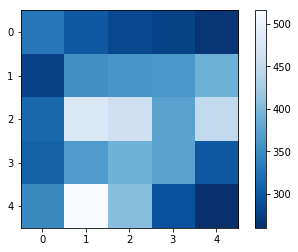

Location :  [420. 679.  89.]


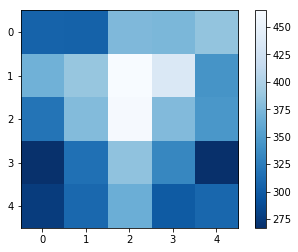

Location :  [478. 634.  88.]


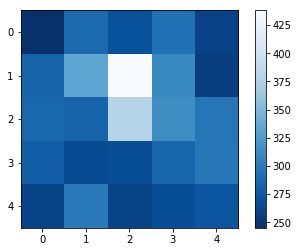

Location :  [431. 641.  88.]


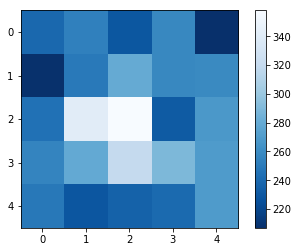

Location :  [440. 686.  90.]


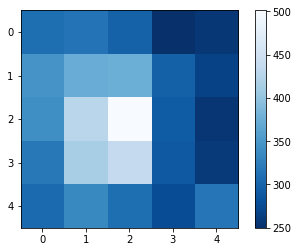

Location :  [520. 780.  98.]


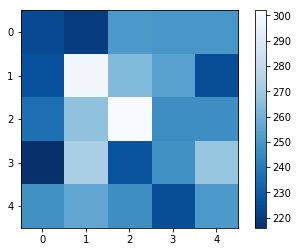

Location :  [590. 608.  89.]


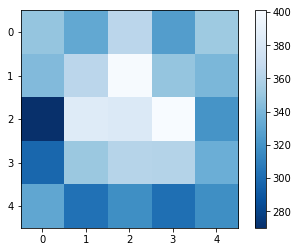

Location :  [429. 629.  90.]


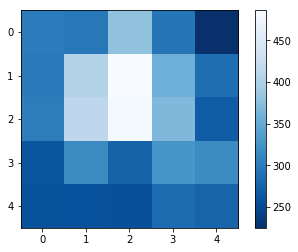

Location :  [438. 635.  89.]


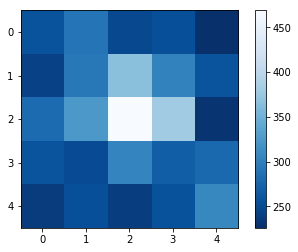

Location :  [534. 602.  89.]


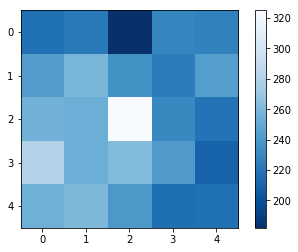

Location :  [469. 610.  89.]


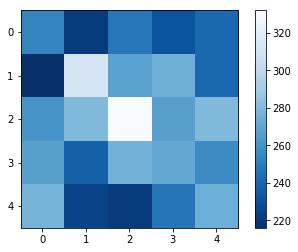

Location :  [468. 633.  92.]


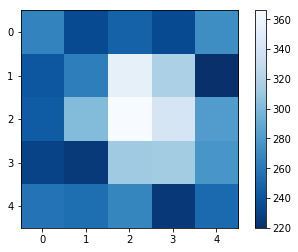

Location :  [473. 643.  92.]


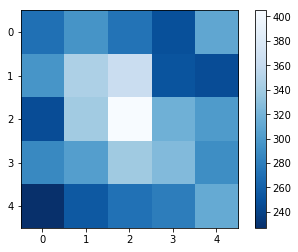

Location :  [436. 647.  91.]


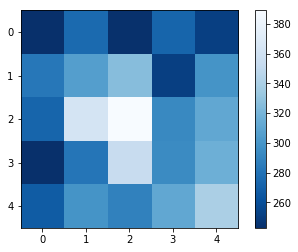

Location :  [438. 659.  92.]


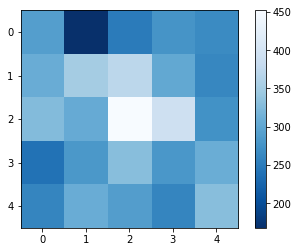

Location :  [422. 707.  95.]


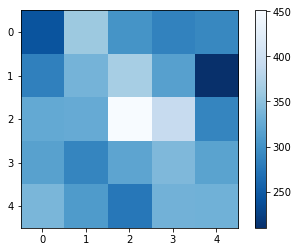

Location :  [530. 774.  95.]


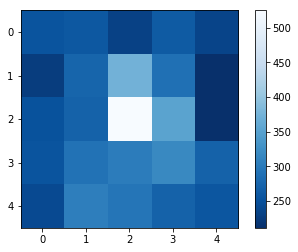

Location :  [440. 642.  92.]


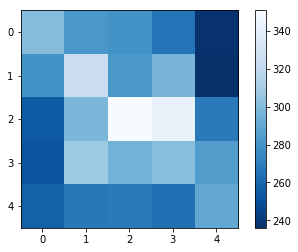

Location :  [469. 550.  91.]


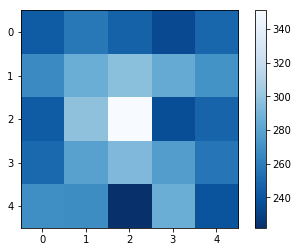

Location :  [567. 627.  89.]


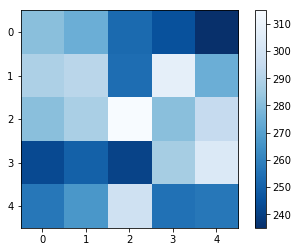

Location :  [476. 653.  95.]


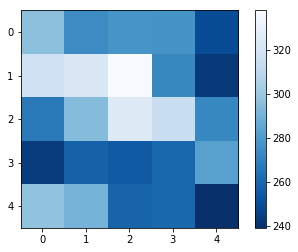

Location :  [441. 678.  94.]


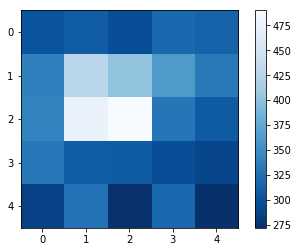

Location :  [425. 702.  94.]


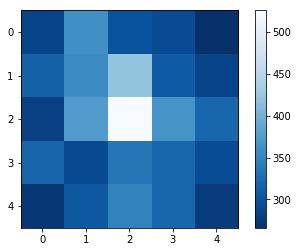

Location :  [494. 542.  92.]


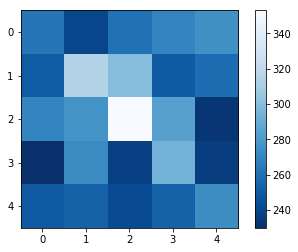

Location :  [544. 614.  93.]


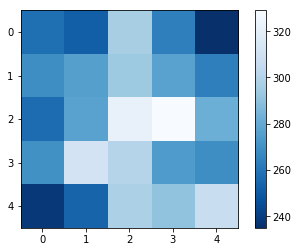

Location :  [443. 612.  94.]


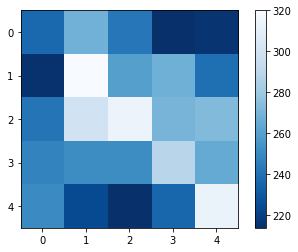

Location :  [481. 622.  93.]


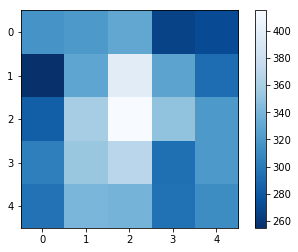

Location :  [469. 651.  93.]


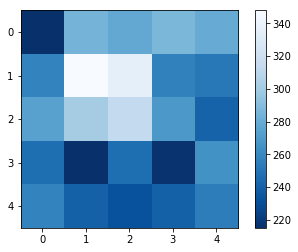

Location :  [430. 672.  96.]


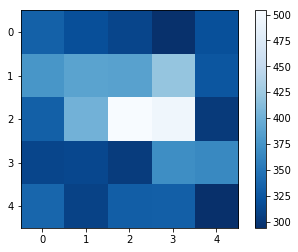

Location :  [442. 678.  89.]


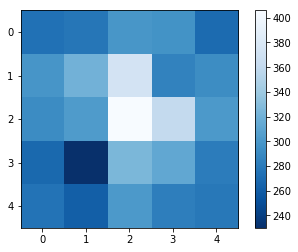

Location :  [431. 683.  97.]


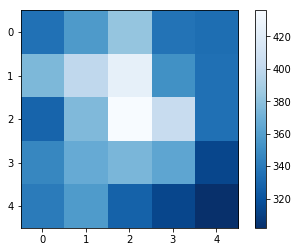

Location :  [561. 778.  93.]


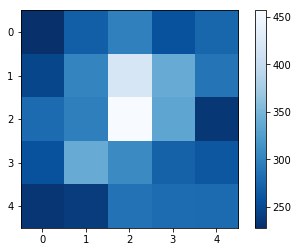

Location :  [569. 786.  89.]


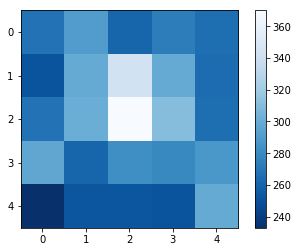

Location :  [593. 541.  89.]


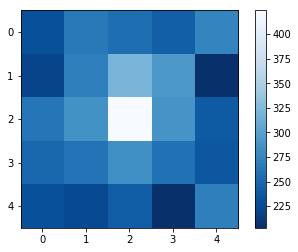

Location :  [600. 551.  92.]


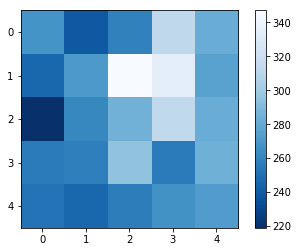

Location :  [547. 557.  88.]


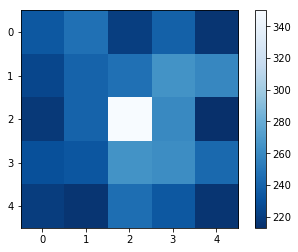

Location :  [473. 613.  93.]


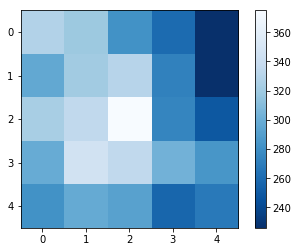

Location :  [429. 612.  95.]


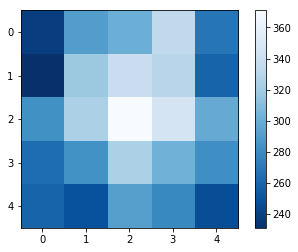

Location :  [428. 638.  97.]


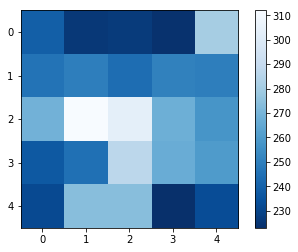

Location :  [537. 773.  95.]


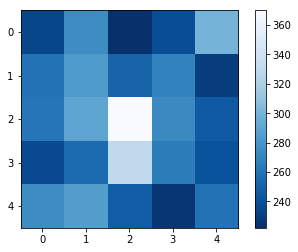

Location :  [539. 770.  92.]


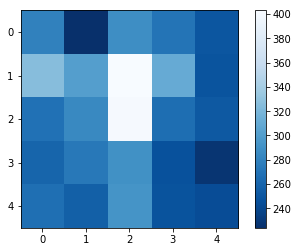

Location :  [495. 563.  92.]


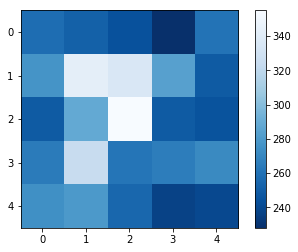

Location :  [459. 574.  94.]


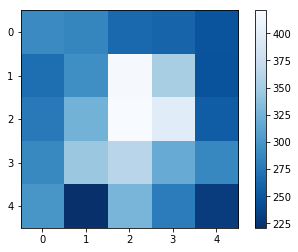

Location :  [478. 617.  87.]


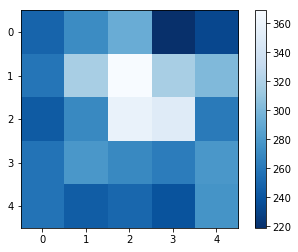

Location :  [488. 627.  96.]


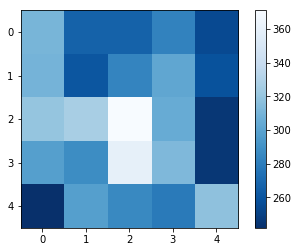

Location :  [431. 663.  95.]


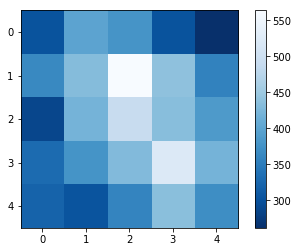

Location :  [443. 687.  96.]


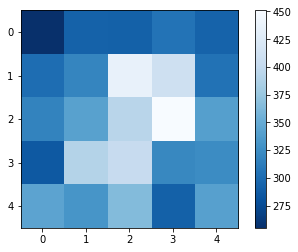

Location :  [437. 703.  98.]


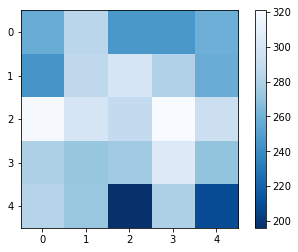

Location :  [528. 455.  90.]


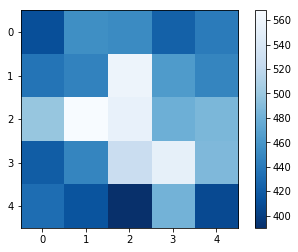

Location :  [531. 557.  89.]


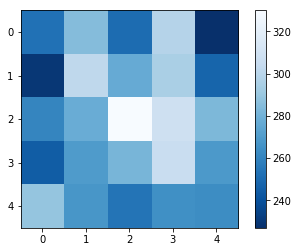

Location :  [501. 560.  94.]


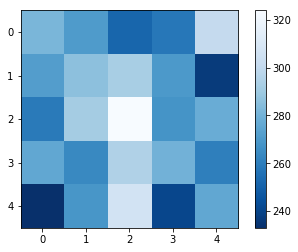

Location :  [483. 572.  95.]


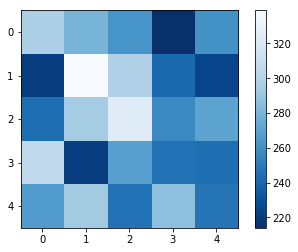

Location :  [436. 626.  96.]


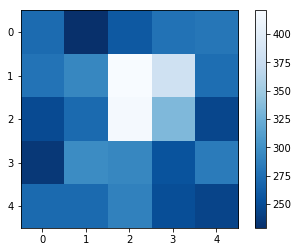

Location :  [477. 642.  99.]


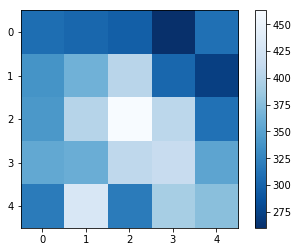

Location :  [421. 645.  96.]


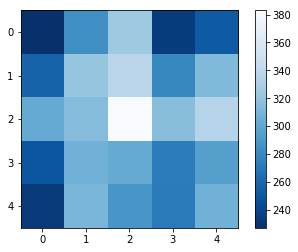

Location :  [454. 664.  97.]


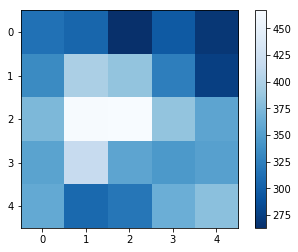

Location :  [436. 731. 102.]


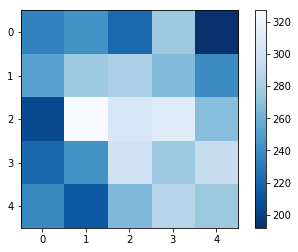

Location :  [585. 782. 102.]


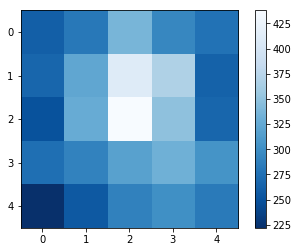

Location :  [517. 554.  97.]


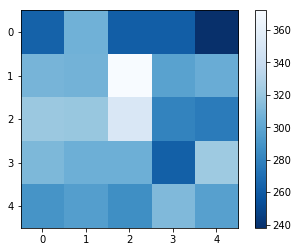

Location :  [495. 557.  94.]


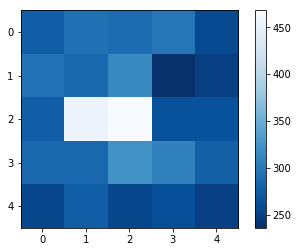

Location :  [502. 566.  96.]


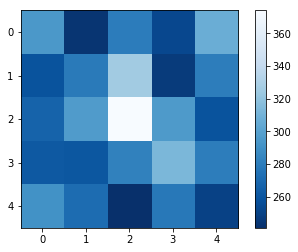

Location :  [453. 569.  95.]


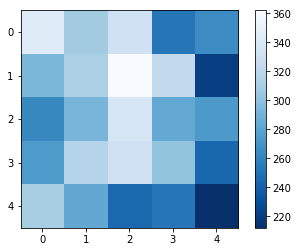

Location :  [543. 586.  95.]


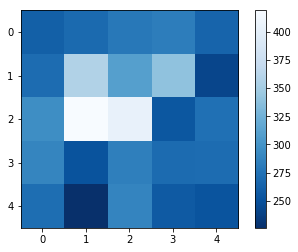

Location :  [462. 622.  97.]


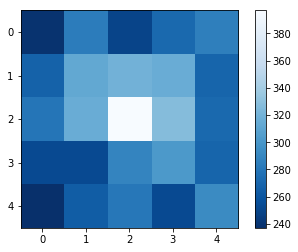

Location :  [443. 657.  98.]


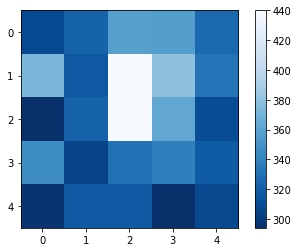

Location :  [420. 687. 100.]


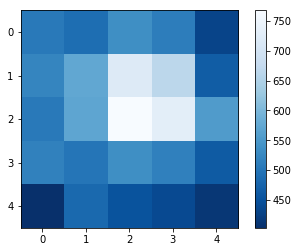

Location :  [449. 694.  99.]


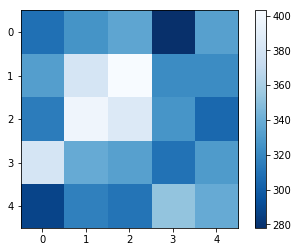

Location :  [450. 714.  99.]


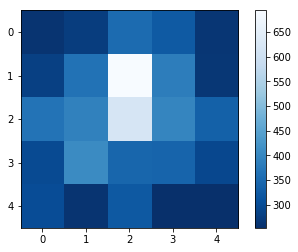

Location :  [451. 708. 103.]


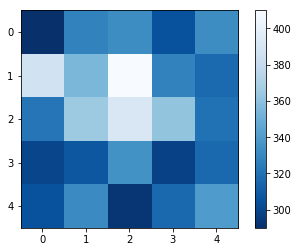

Location :  [517. 572.  97.]


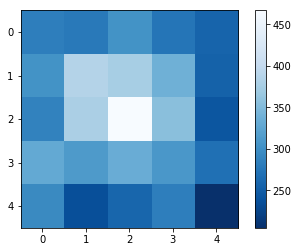

Location :  [472. 618.  98.]


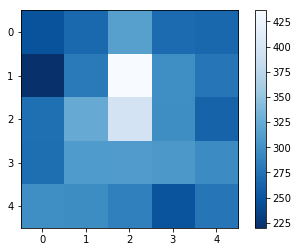

Location :  [493. 619.  99.]


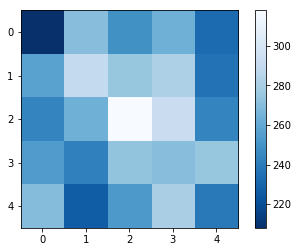

Location :  [468. 620.  98.]


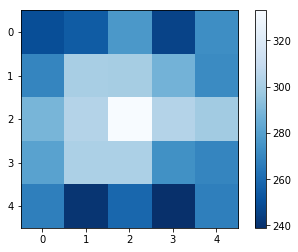

Location :  [446. 668. 102.]


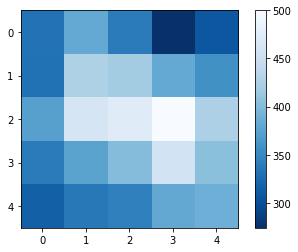

Location :  [446. 678.  98.]


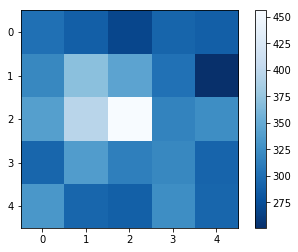

Location :  [522. 561.  95.]


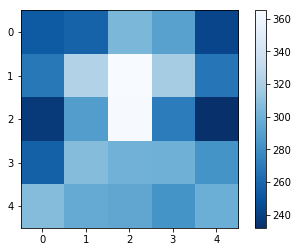

Location :  [521. 574.  93.]


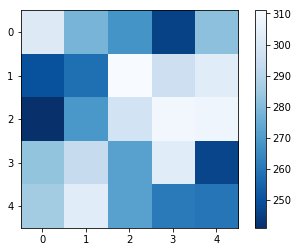

Location :  [489. 612. 100.]


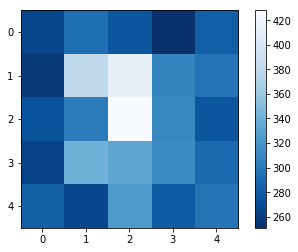

Location :  [433. 648. 103.]


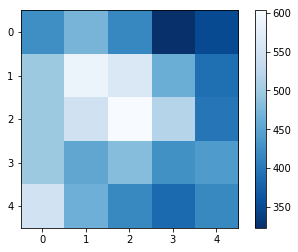

Location :  [452. 657. 100.]


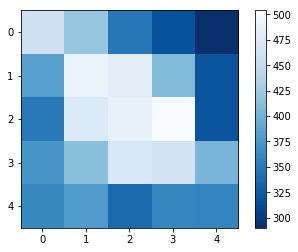

Location :  [419. 675.  94.]


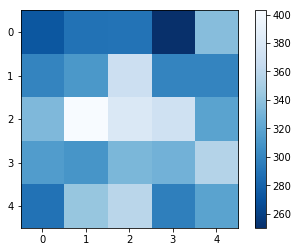

Location :  [456. 711. 103.]


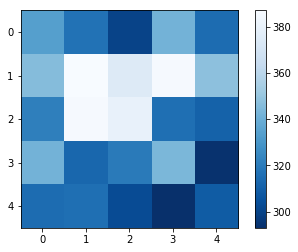

Location :  [446. 723. 102.]


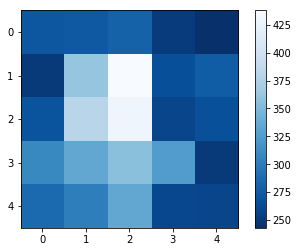

Location :  [498. 582.  99.]


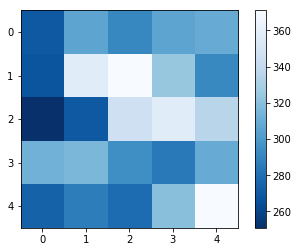

Location :  [472. 627.  93.]


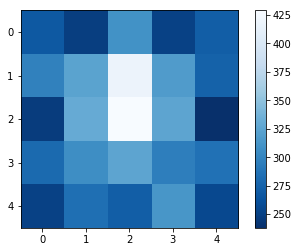

Location :  [484. 619.  99.]


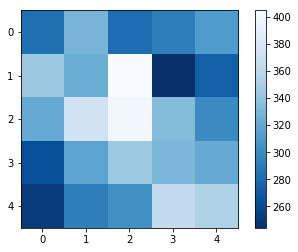

Location :  [430. 663. 102.]


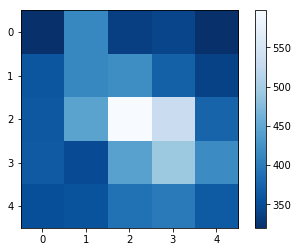

Location :  [435. 675. 103.]


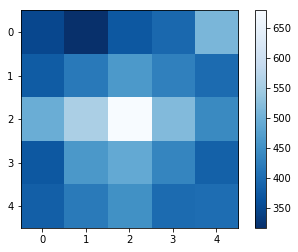

Location :  [443. 687. 102.]


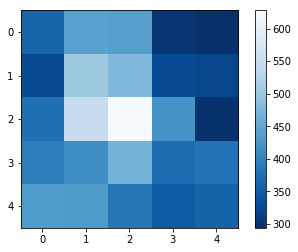

Location :  [511. 783.  98.]


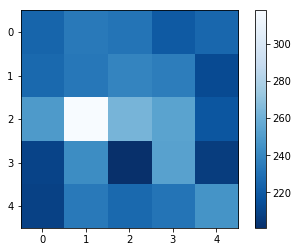

Location :  [449. 650. 102.]


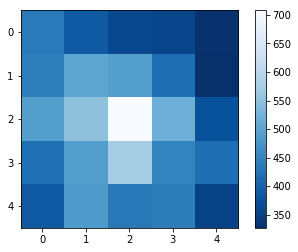

Location :  [449. 669. 103.]


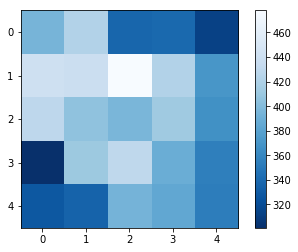

Location :  [433. 684. 102.]


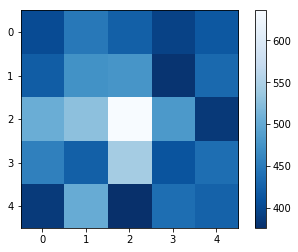

Location :  [454. 685. 101.]


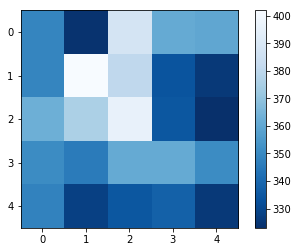

Location :  [462. 731. 105.]


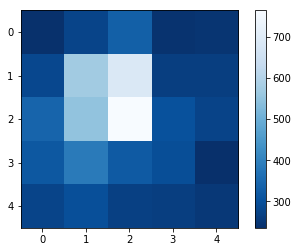

Location :  [479. 545.  92.]


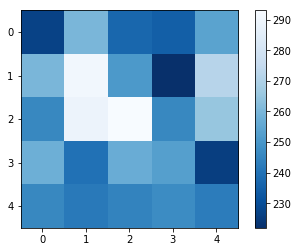

Location :  [489. 553.  97.]


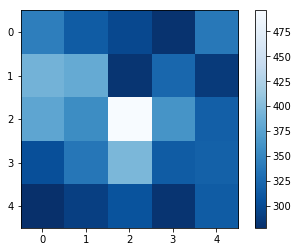

Location :  [504. 578.  97.]


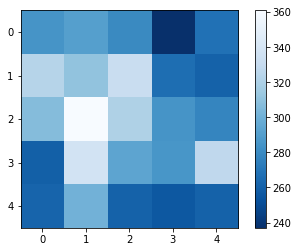

Location :  [430. 645. 103.]


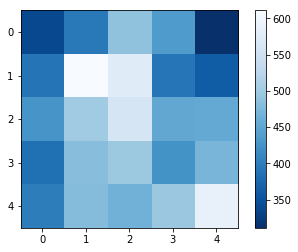

Location :  [452. 674. 104.]


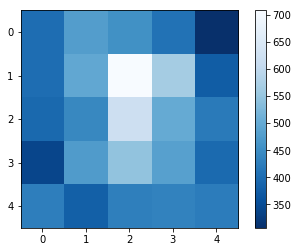

Location :  [460. 675. 104.]


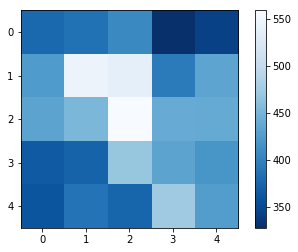

Location :  [432. 703. 101.]


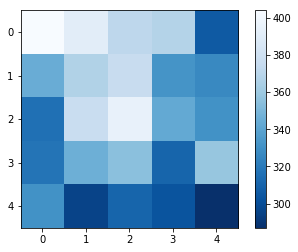

Location :  [459. 706. 107.]


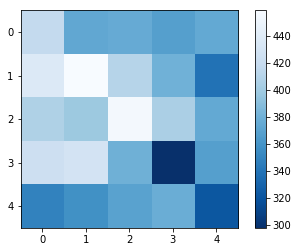

Location :  [505. 557. 100.]


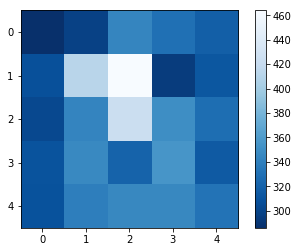

Location :  [476. 584. 101.]


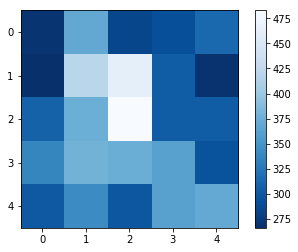

Location :  [448. 622. 103.]


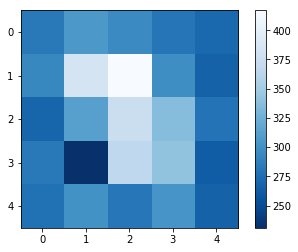

Location :  [437. 661. 104.]


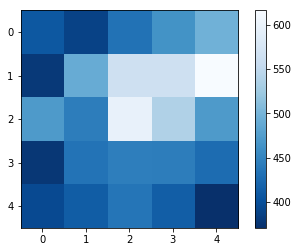

Location :  [422. 668. 101.]


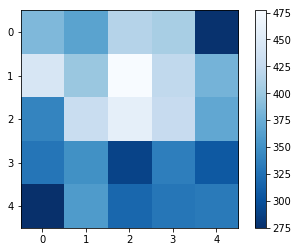

Location :  [439. 673. 105.]


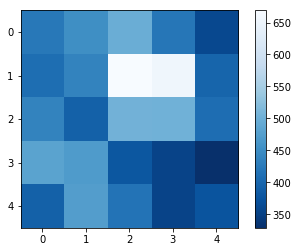

Location :  [446. 711. 106.]


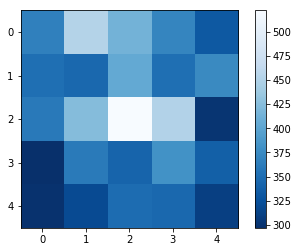

Location :  [429. 711. 105.]


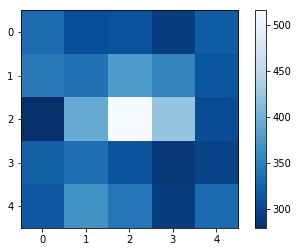

Location :  [513. 565.  99.]


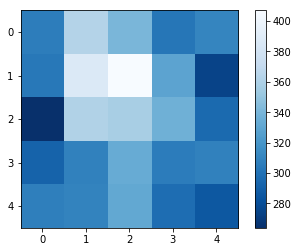

Location :  [463. 564. 101.]


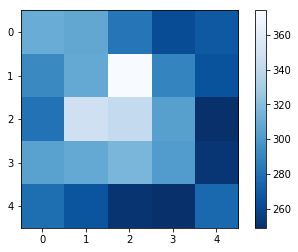

Location :  [565. 581. 103.]


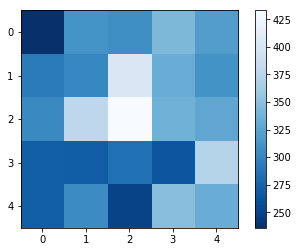

Location :  [463. 570. 104.]


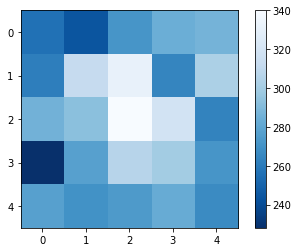

Location :  [481. 581. 100.]


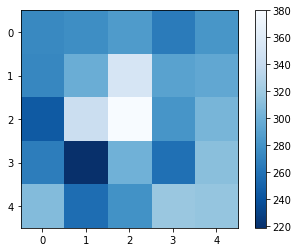

Location :  [477. 586. 104.]


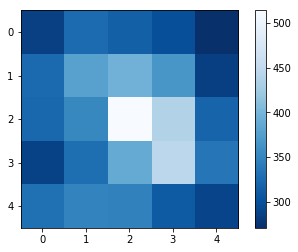

Location :  [474. 590. 103.]


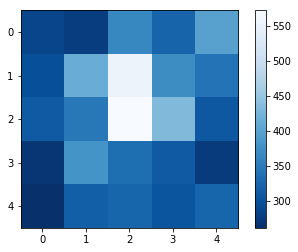

Location :  [482. 634. 101.]


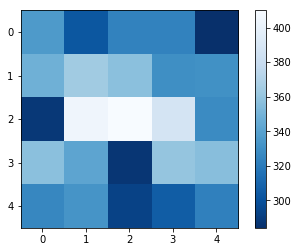

Location :  [446. 692. 108.]


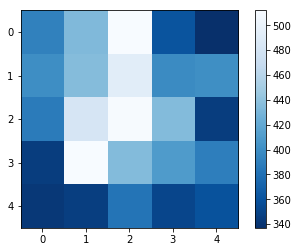

Location :  [595. 772. 109.]


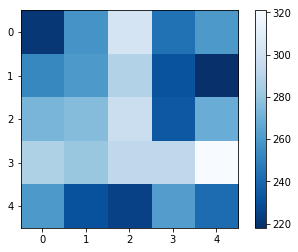

Location :  [473. 549. 101.]


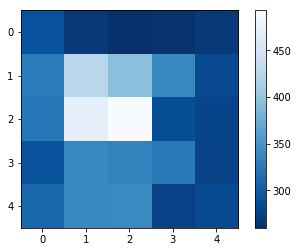

Location :  [492. 582. 104.]


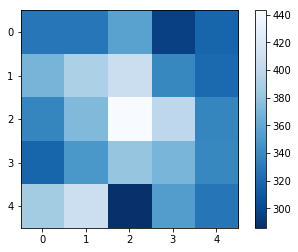

Location :  [511. 586. 105.]


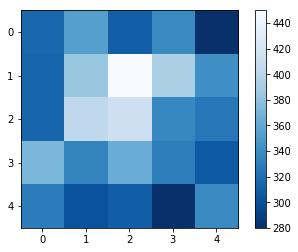

Location :  [502. 584. 105.]


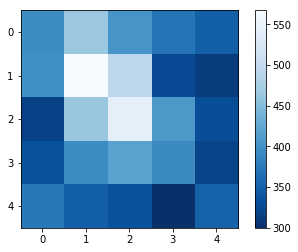

Location :  [484. 625.  99.]


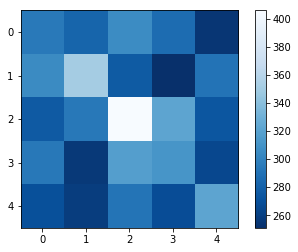

Location :  [490. 631. 106.]


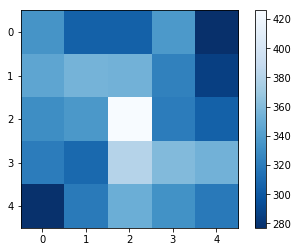

Location :  [449. 628. 106.]


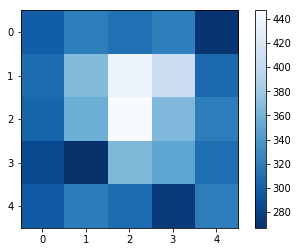

Location :  [465. 665. 107.]


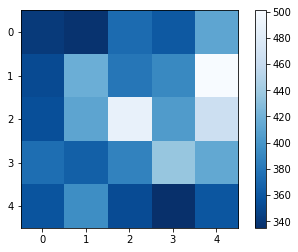

Location :  [457. 665. 102.]


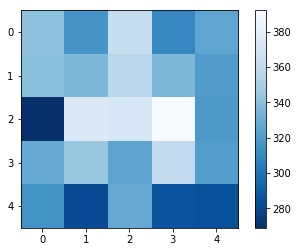

Location :  [431. 721. 109.]


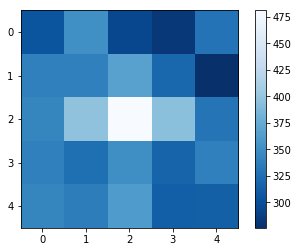

Location :  [452. 743. 109.]


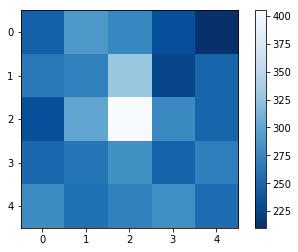

Location :  [462. 630.  98.]


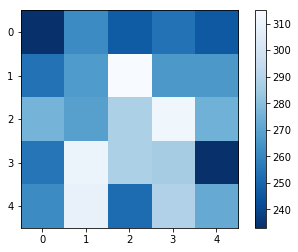

Location :  [494. 634. 107.]


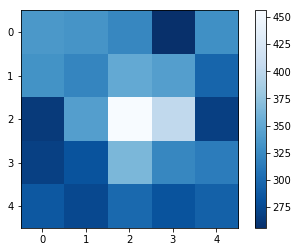

Location :  [466. 651. 104.]


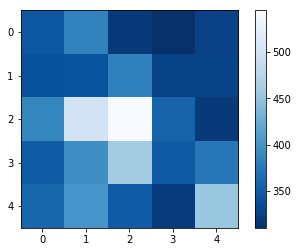

Location :  [474. 655. 107.]


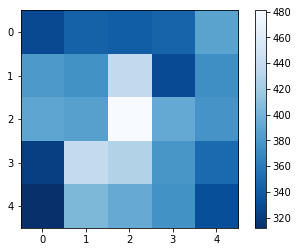

Location :  [449. 667. 108.]


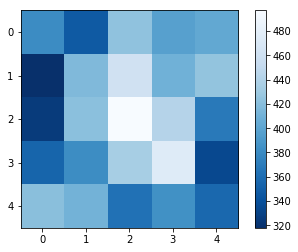

Location :  [453. 677. 109.]


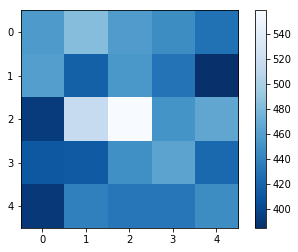

Location :  [429. 716. 110.]


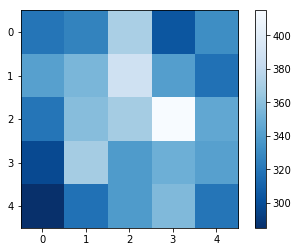

Location :  [437. 732. 110.]


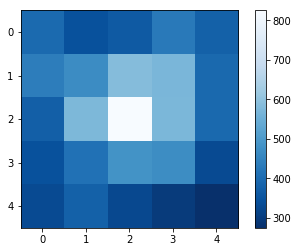

Location :  [452. 739. 110.]


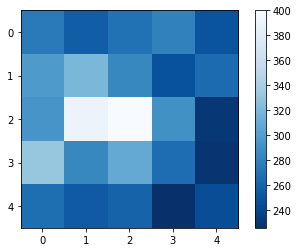

Location :  [482. 466. 107.]


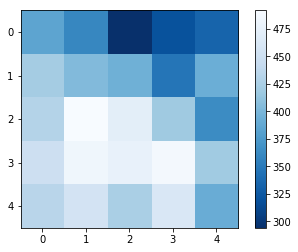

Location :  [441. 612. 105.]


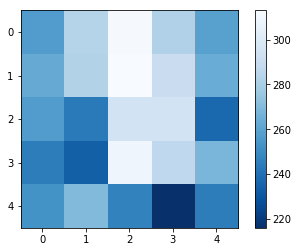

Location :  [488. 626. 107.]


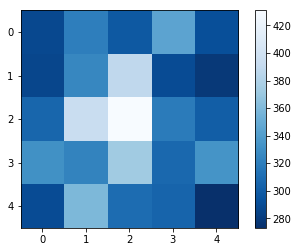

Location :  [438. 640. 106.]


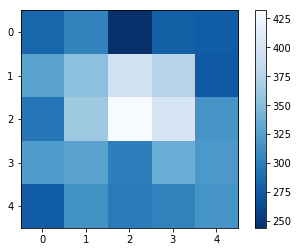

Location :  [447. 650. 107.]


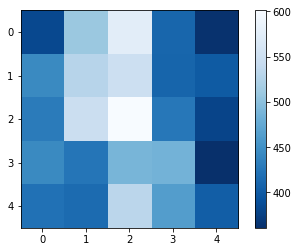

Location :  [439. 653. 103.]


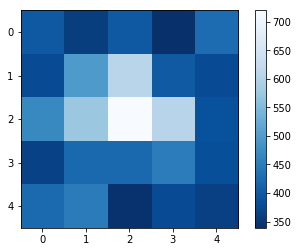

Location :  [449. 663. 109.]


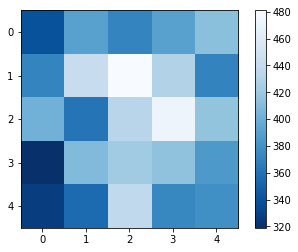

Location :  [438. 703. 110.]


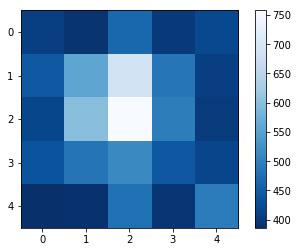

Location :  [446. 704. 111.]


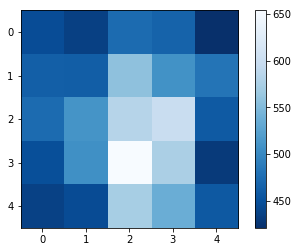

Location :  [445. 737. 111.]


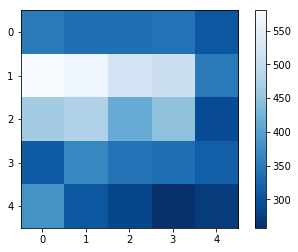

Location :  [465. 743. 111.]


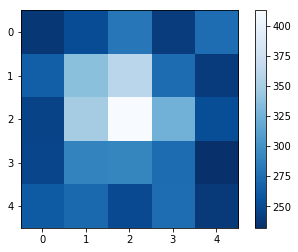

Location :  [446. 747. 110.]


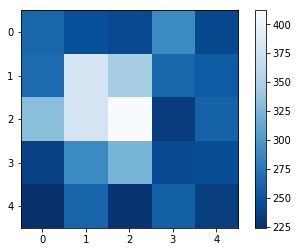

Location :  [544. 454. 103.]


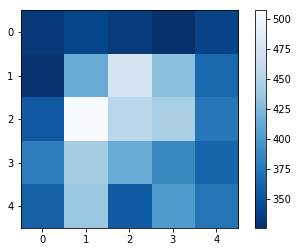

Location :  [510. 464.  98.]


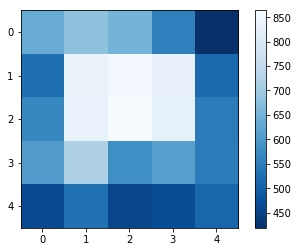

Location :  [472. 632. 108.]


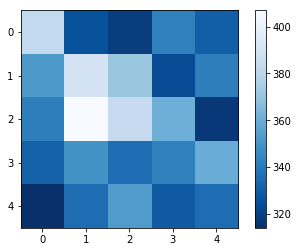

Location :  [479. 631. 109.]


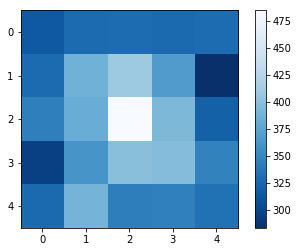

Location :  [444. 639. 107.]


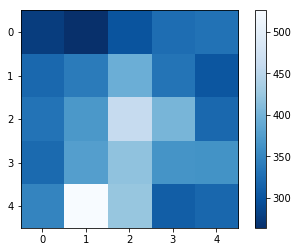

Location :  [478. 646. 106.]


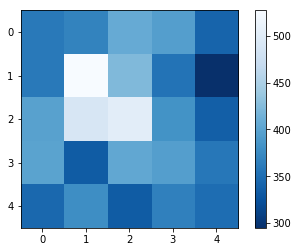

Location :  [442. 653. 111.]


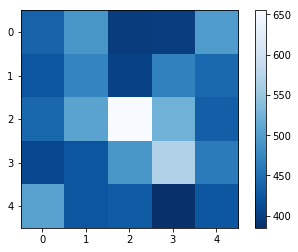

Location :  [488. 662. 111.]


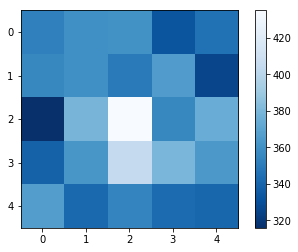

Location :  [430. 667. 107.]


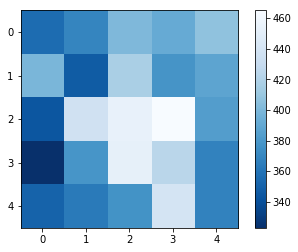

Location :  [454. 666. 108.]


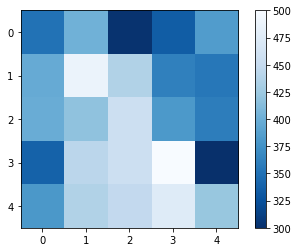

Location :  [436. 670. 111.]


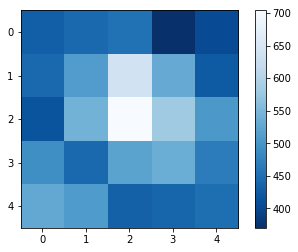

Location :  [443. 672. 114.]


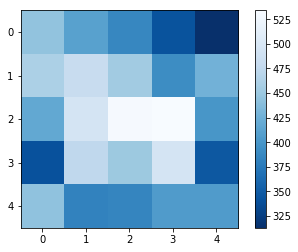

Location :  [446. 684. 111.]


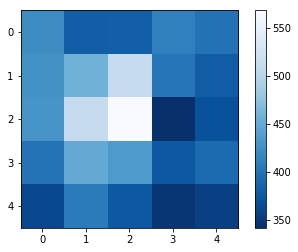

Location :  [434. 683. 108.]


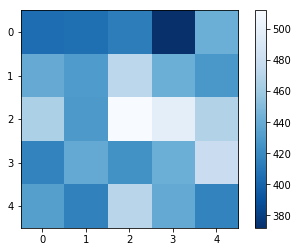

Location :  [439. 686. 112.]


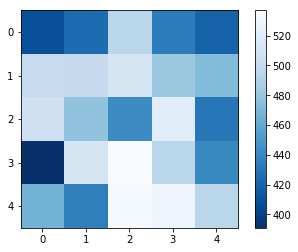

Location :  [450. 709. 112.]


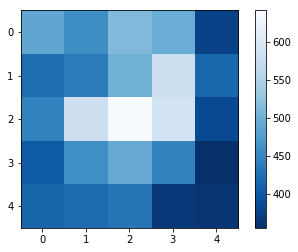

Location :  [450. 717. 112.]


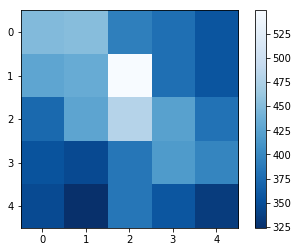

Location :  [518. 744. 106.]


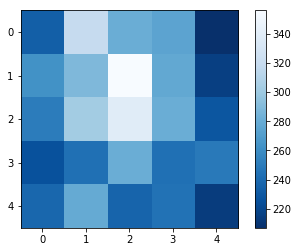

Location :  [477. 745. 113.]


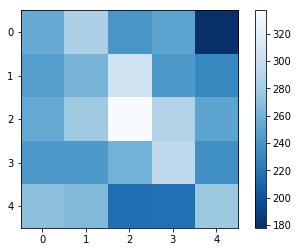

Location :  [512. 446. 103.]


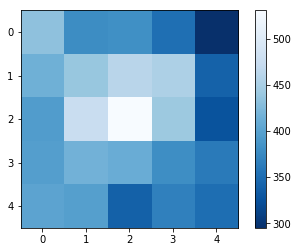

Location :  [513. 462. 105.]


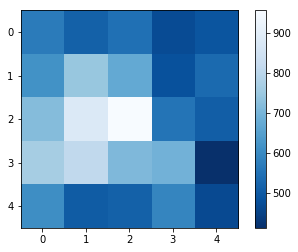

Location :  [604. 539. 108.]


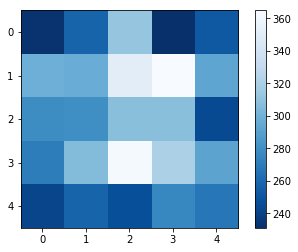

Location :  [481. 623. 106.]


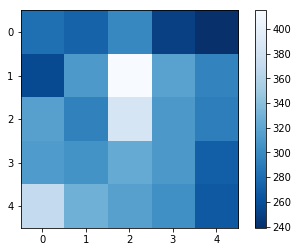

Location :  [488. 656. 111.]


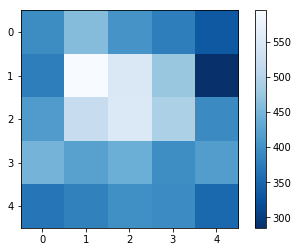

Location :  [450. 657. 104.]


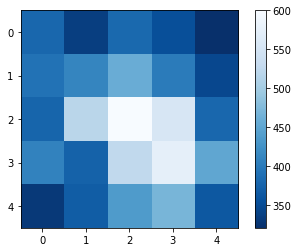

Location :  [440. 678. 112.]


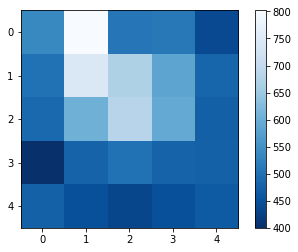

Location :  [453. 722. 110.]


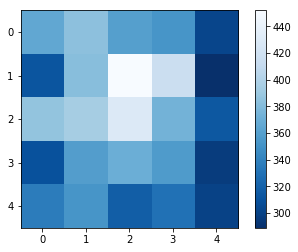

Location :  [441. 715. 112.]


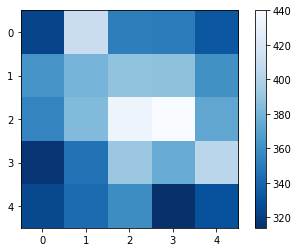

Location :  [452. 722. 113.]


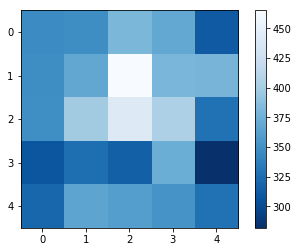

Location :  [441. 718. 107.]


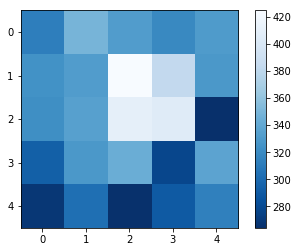

Location :  [439. 728. 113.]


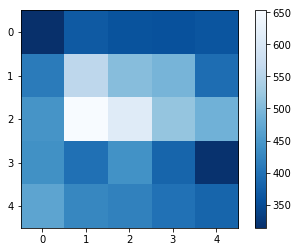

Location :  [609. 760. 113.]


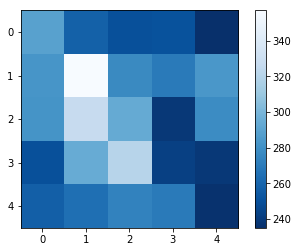

Location :  [457. 467. 105.]


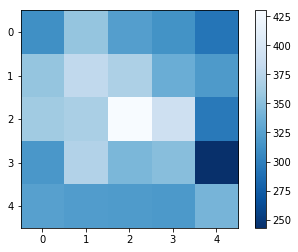

Location :  [510. 545. 108.]


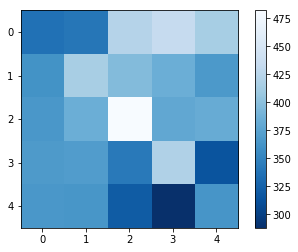

Location :  [456. 670. 116.]


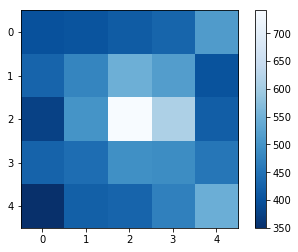

Location :  [431. 672. 112.]


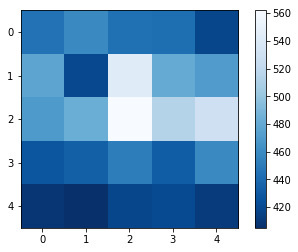

Location :  [445. 677. 112.]


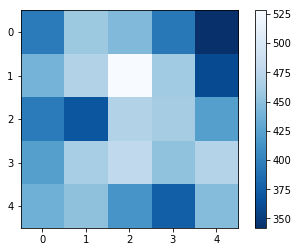

Location :  [476. 725. 113.]


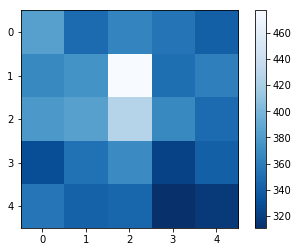

Location :  [538. 468. 110.]


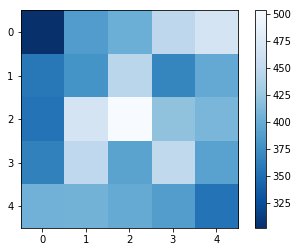

Location :  [465. 593. 110.]


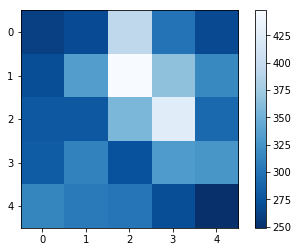

Location :  [468. 627. 112.]


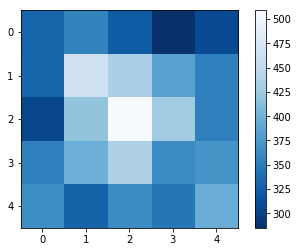

Location :  [453. 673. 112.]


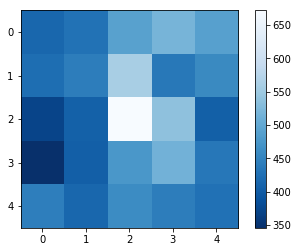

Location :  [463. 705. 113.]


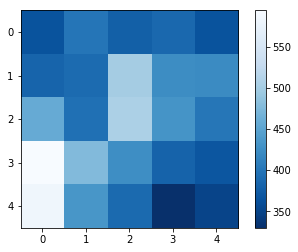

Location :  [560. 581. 115.]


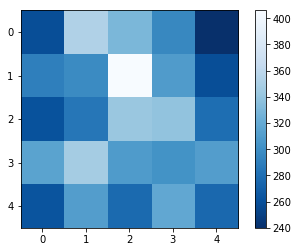

Location :  [470. 590. 111.]


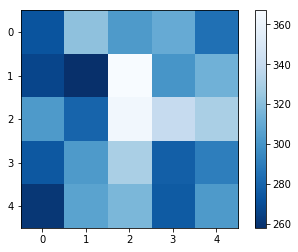

Location :  [467. 631. 115.]


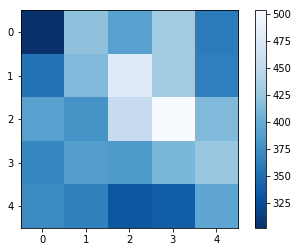

Location :  [455. 643. 113.]


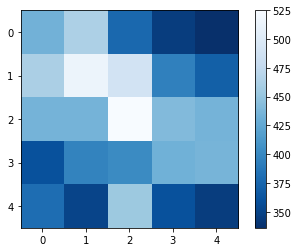

Location :  [447. 651. 116.]


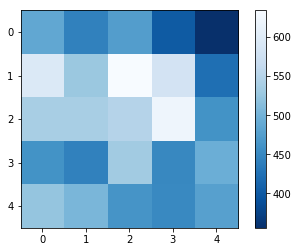

Location :  [467. 659. 113.]


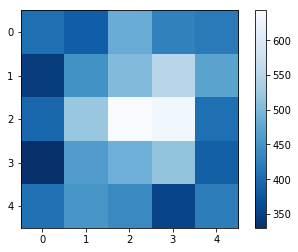

Location :  [445. 712. 115.]


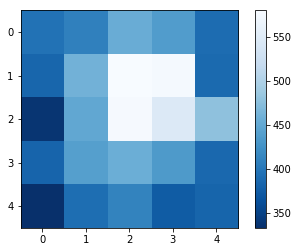

Location :  [469. 745. 114.]


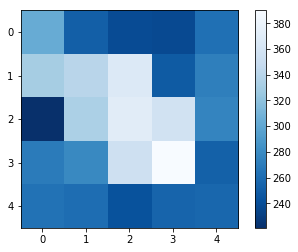

Location :  [561. 481. 112.]


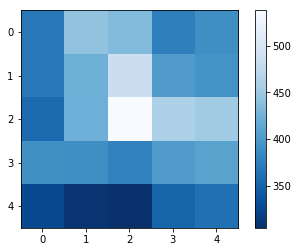

Location :  [534. 590. 113.]


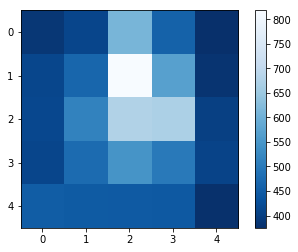

Location :  [527. 591. 113.]


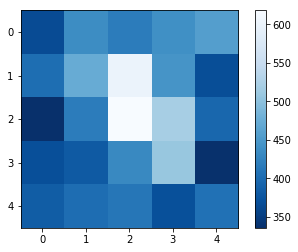

Location :  [479. 652. 115.]


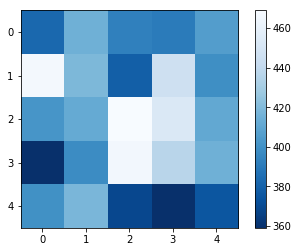

Location :  [442. 721. 115.]


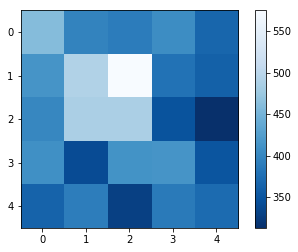

Location :  [458. 588. 111.]


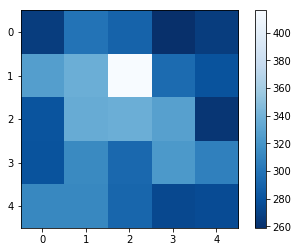

Location :  [481. 630. 115.]


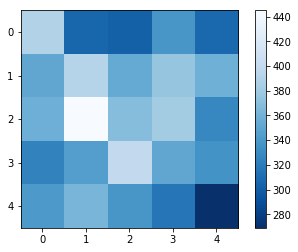

Location :  [447. 690. 117.]


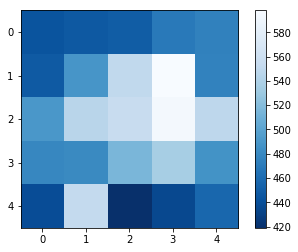

Location :  [451. 715. 117.]


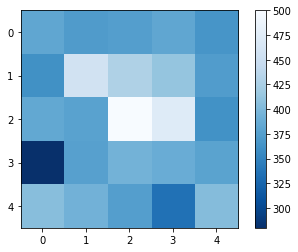

Location :  [431. 716. 117.]


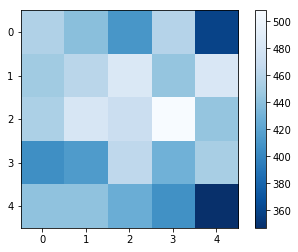

Location :  [462. 734. 115.]


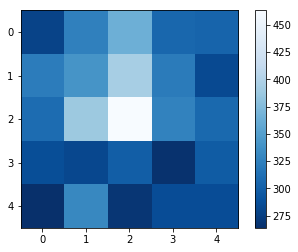

Location :  [437. 724. 115.]


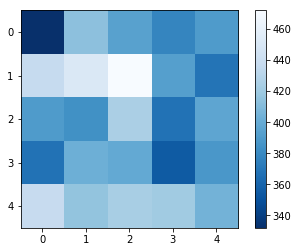

Location :  [467. 783. 122.]


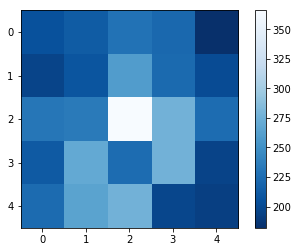

Location :  [568. 494. 113.]


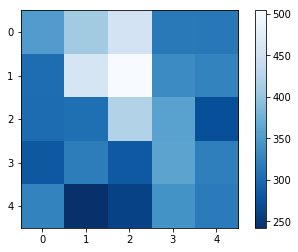

Location :  [570. 551. 116.]


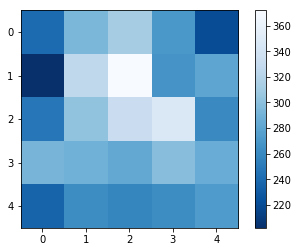

Location :  [465. 704. 119.]


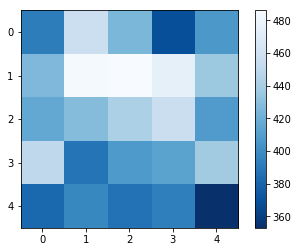

Location :  [467. 754. 121.]


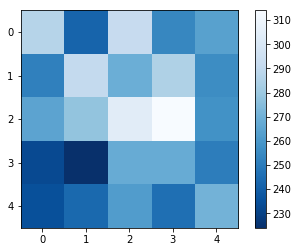

Location :  [527. 457. 107.]


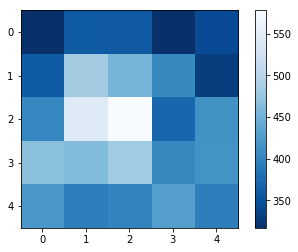

Location :  [470. 627. 116.]


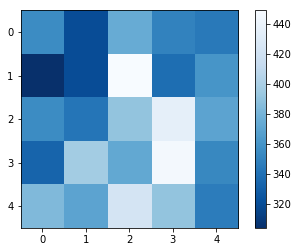

Location :  [469. 642. 117.]


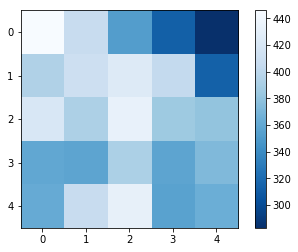

Location :  [479. 648. 115.]


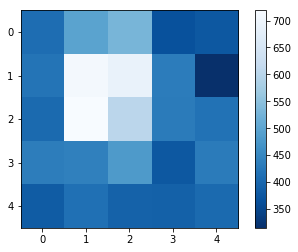

Location :  [455. 695. 118.]


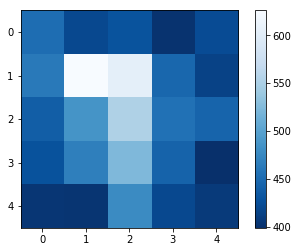

Location :  [460. 706. 115.]


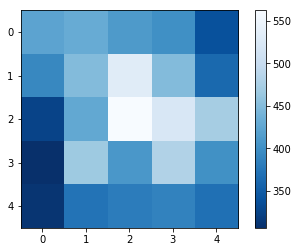

Location :  [456. 722. 120.]


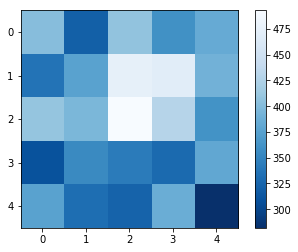

Location :  [474. 730. 118.]


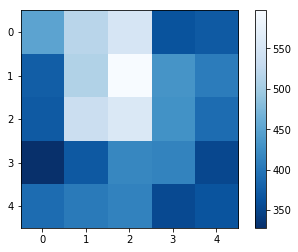

Location :  [468. 727. 120.]


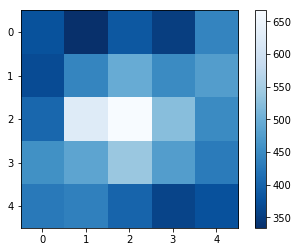

Location :  [607. 454. 105.]


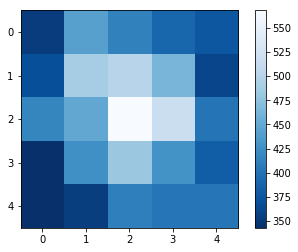

Location :  [555. 449. 113.]


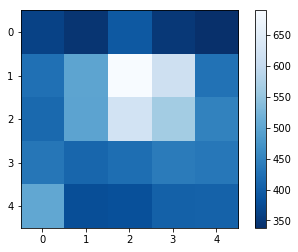

Location :  [579. 469. 113.]


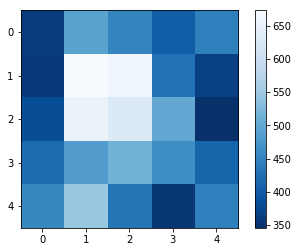

Location :  [582. 690. 120.]


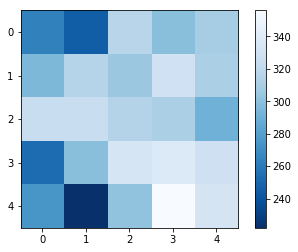

Location :  [443. 731. 118.]


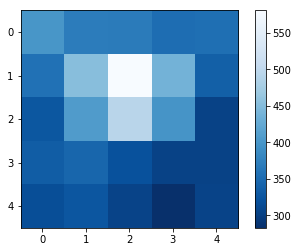

Location :  [511. 456. 106.]


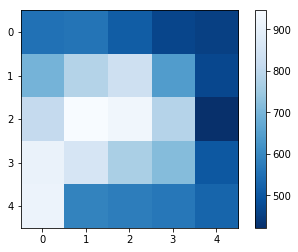

Location :  [430. 664. 119.]


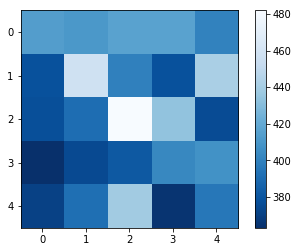

Location :  [589. 690. 125.]


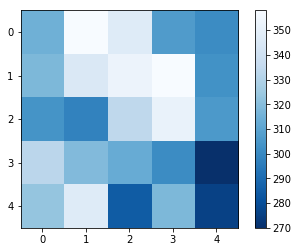

Location :  [479. 697. 123.]


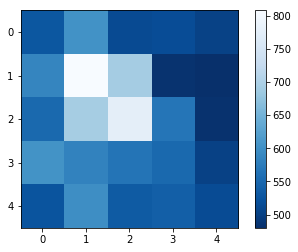

Location :  [468. 747. 123.]


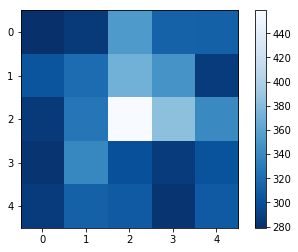

Location :  [485. 669. 114.]


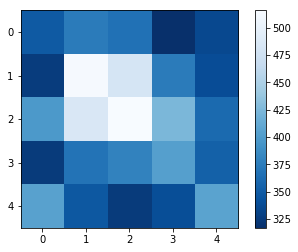

Location :  [467. 697. 123.]


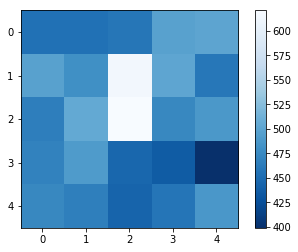

Location :  [454. 710. 121.]


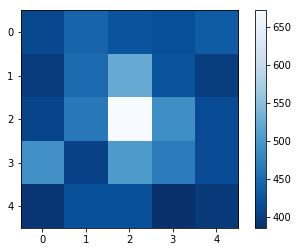

Location :  [433. 737. 122.]


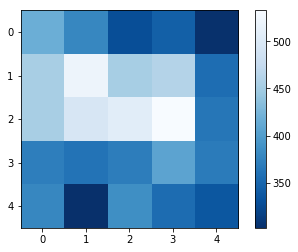

Location :  [454. 770. 115.]


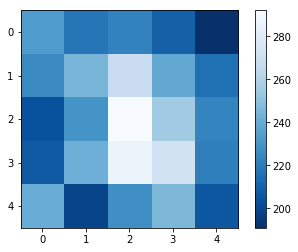

Location :  [483. 474. 112.]


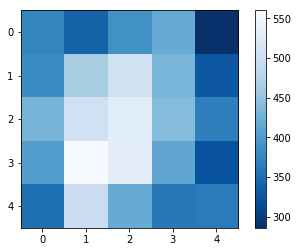

Location :  [580. 504. 119.]


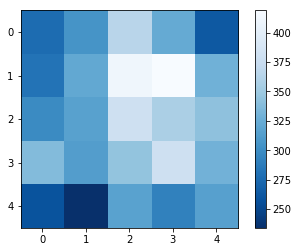

Location :  [509. 669. 120.]


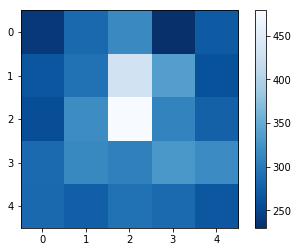

Location :  [488. 684. 127.]


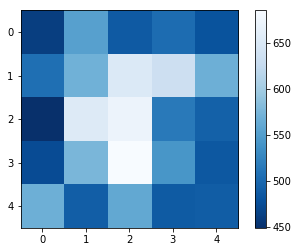

Location :  [448. 685. 121.]


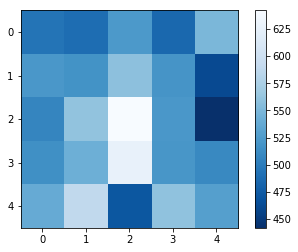

Location :  [438. 739. 125.]


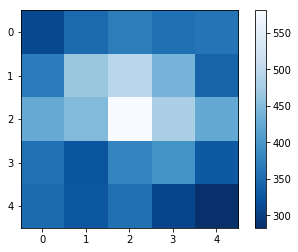

Location :  [599. 518. 118.]


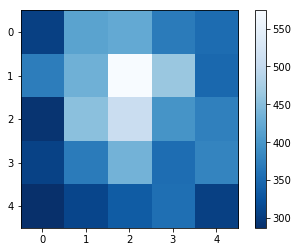

Location :  [534. 622. 122.]


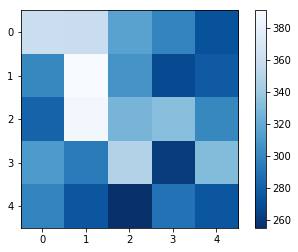

Location :  [490. 676. 122.]


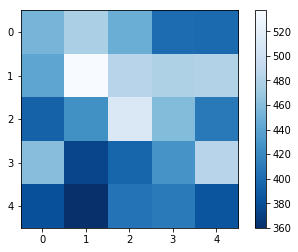

Location :  [469. 713. 128.]


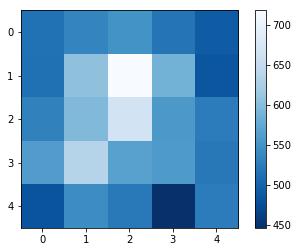

Location :  [462. 725. 125.]


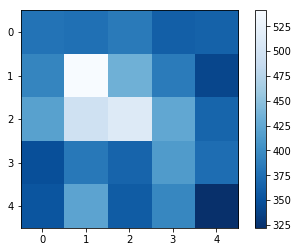

Location :  [533. 472. 119.]


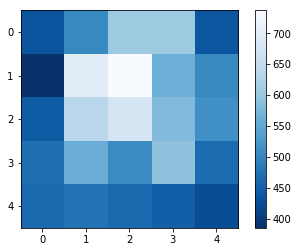

Location :  [612. 524. 120.]


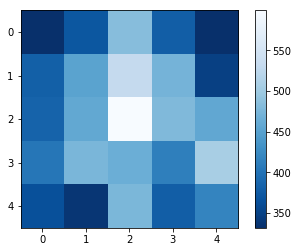

Location :  [481. 662. 126.]


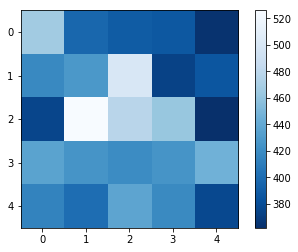

Location :  [440. 724. 119.]


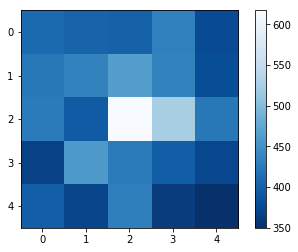

Location :  [438. 730. 127.]


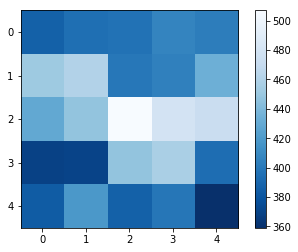

Location :  [442. 731. 126.]


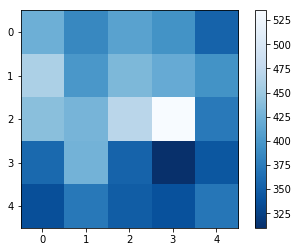

Location :  [475. 622. 124.]


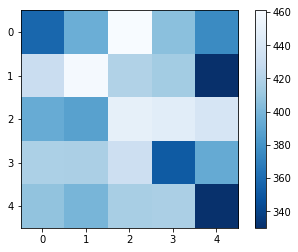

Location :  [476. 658. 124.]


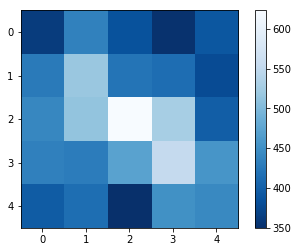

Location :  [488. 689. 122.]


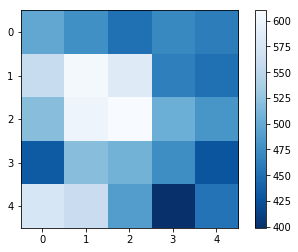

Location :  [457. 703. 126.]


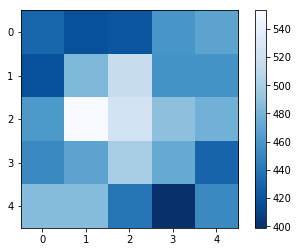

Location :  [462. 707. 126.]


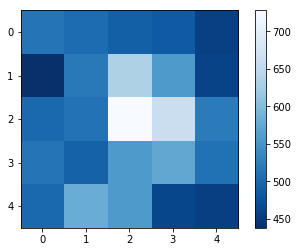

Location :  [449. 720. 126.]


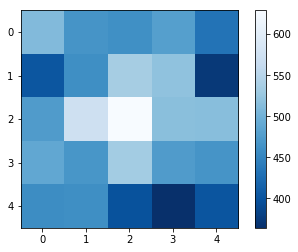

Location :  [454. 715. 121.]


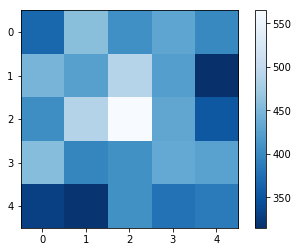

Location :  [595. 511. 117.]


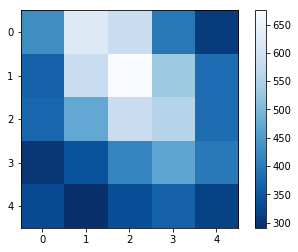

Location :  [622. 532. 124.]


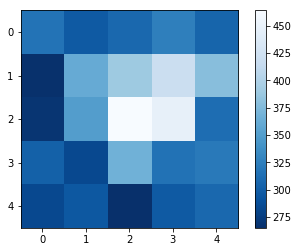

Location :  [465. 702. 126.]


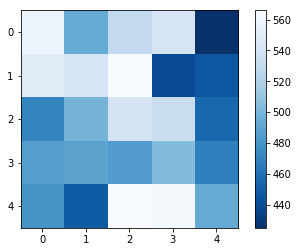

Location :  [446. 699. 120.]


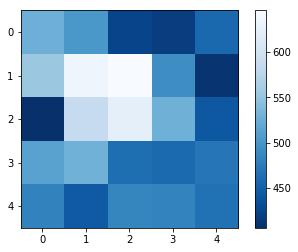

Location :  [484. 752. 132.]


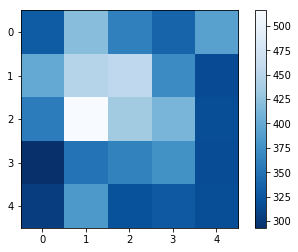

Location :  [560. 592. 123.]


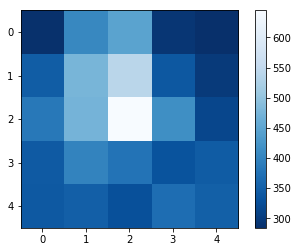

Location :  [454. 658. 126.]


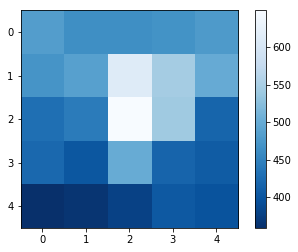

Location :  [460. 666. 127.]


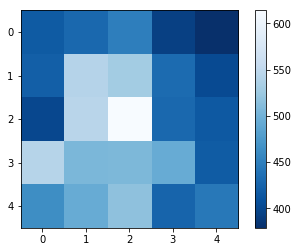

Location :  [462. 684. 128.]


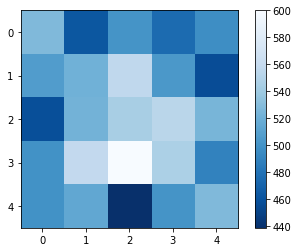

Location :  [446. 737. 127.]


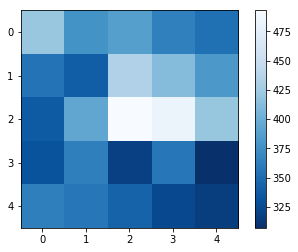

Location :  [473. 741. 129.]


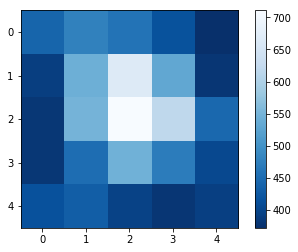

Location :  [549. 451. 120.]


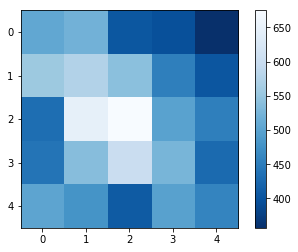

Location :  [439. 737. 131.]


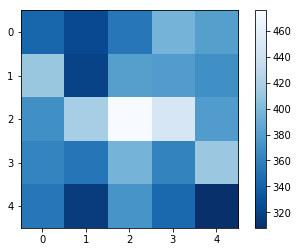

Location :  [468. 758. 130.]


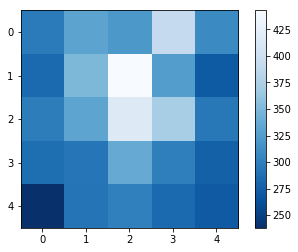

Location :  [452. 674. 130.]


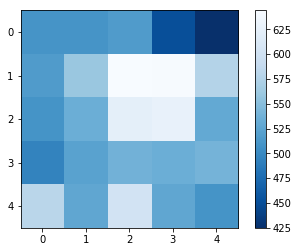

Location :  [550. 689. 134.]


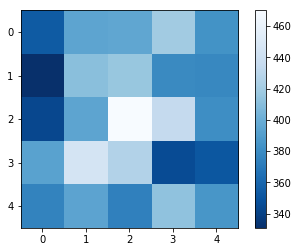

Location :  [466. 754. 130.]


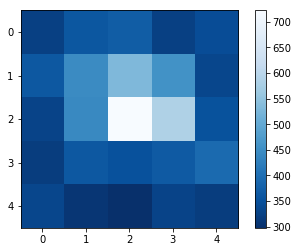

Location :  [495. 759. 131.]


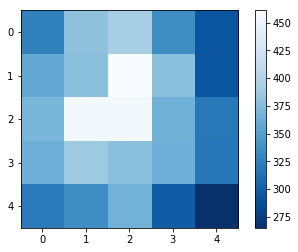

Location :  [492. 641. 124.]


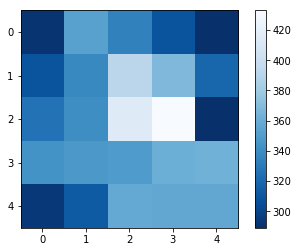

Location :  [504. 688. 128.]


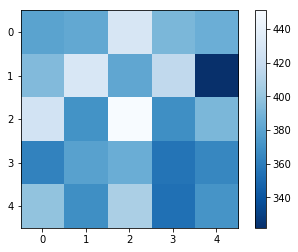

Location :  [459. 699. 128.]


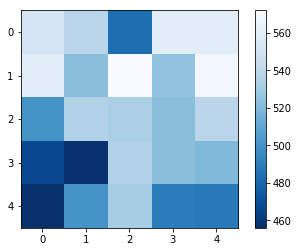

Location :  [453. 729. 132.]


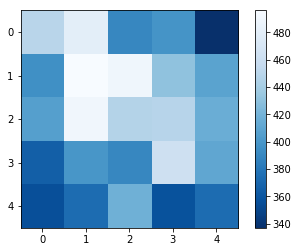

Location :  [467. 745. 131.]


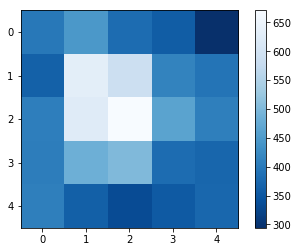

Location :  [473. 751. 131.]


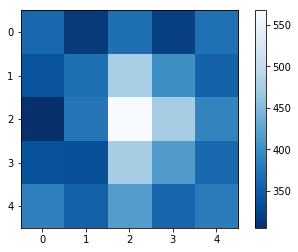

Location :  [481. 635. 131.]


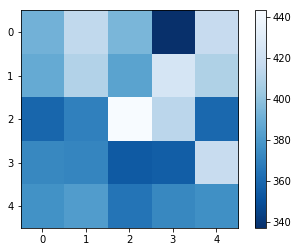

Location :  [486. 647. 131.]


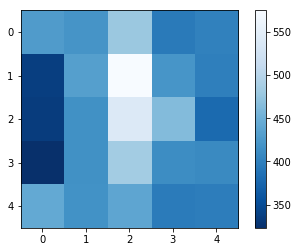

Location :  [491. 745. 138.]


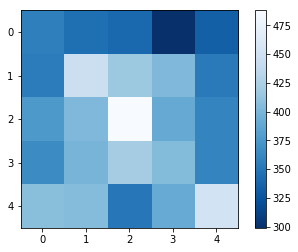

Location :  [449. 740. 131.]


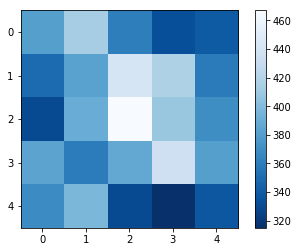

Location :  [430. 749. 130.]


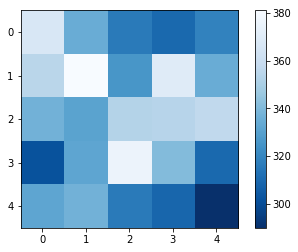

Location :  [473. 753. 136.]


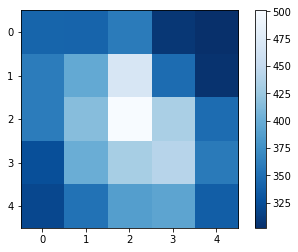

Location :  [502. 677. 132.]


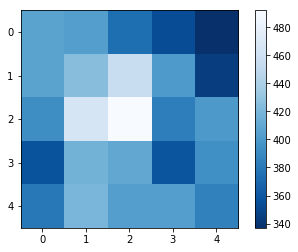

Location :  [454. 736. 133.]


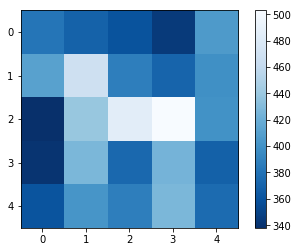

Location :  [456. 733. 133.]


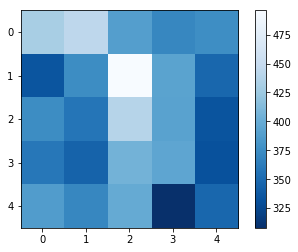

Location :  [475. 741. 136.]


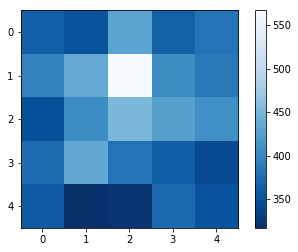

Location :  [488. 735. 138.]


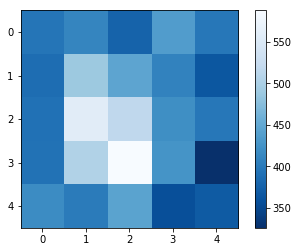

Location :  [465. 745. 137.]


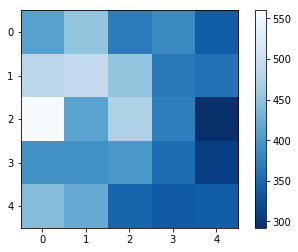

Location :  [584. 479. 121.]


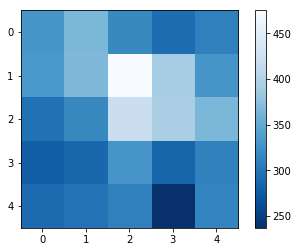

Location :  [571. 489. 128.]


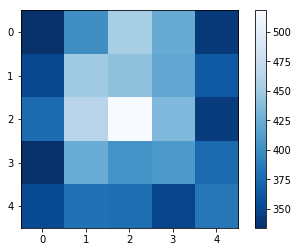

Location :  [584. 519. 124.]


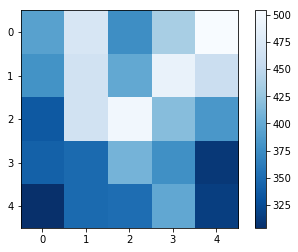

Location :  [535. 536. 129.]


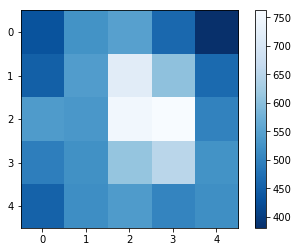

Location :  [498. 683. 129.]


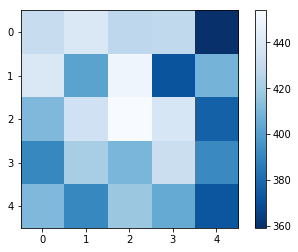

Location :  [459. 748. 135.]


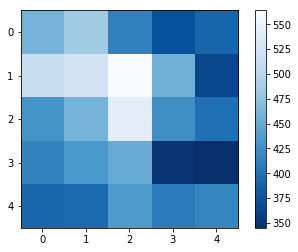

Location :  [487. 630. 134.]


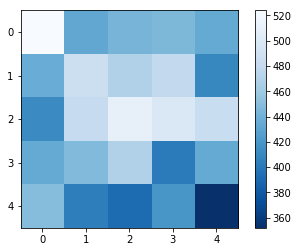

Location :  [512. 741. 132.]


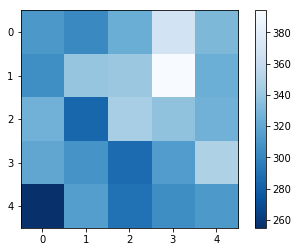

Location :  [482. 746. 138.]


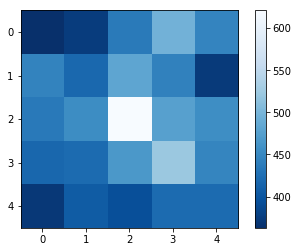

Location :  [459. 740. 134.]


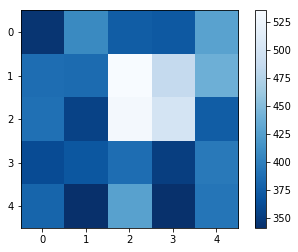

Location :  [484. 644. 134.]


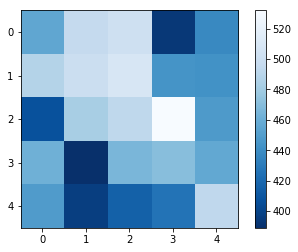

Location :  [463. 737. 135.]


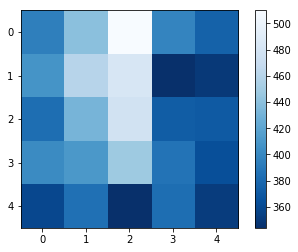

Location :  [472. 745. 139.]


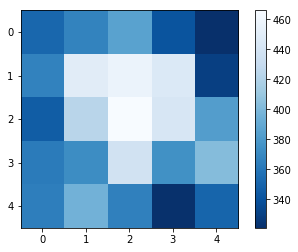

Location :  [480. 751. 139.]


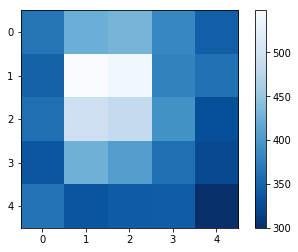

In [6]:
study_id = '1-0CN2'
tp = 2

def load_tif_or_tiff(ipal_path,image):
    """
    Specifically for our pallium images, 
    checks if the file with tiff or tif exists and loads if it does.
    """
    if Path(f'{ipal_path}Image_{image}.ome.tiff').exists ():
        volume = tif.imread((f'{ipal_path}Image_{image}.ome.tiff'))
    elif Path(f'{ipal_path}Image_{image}.ome.tif').exists ():
        volume = tif.imread((f'{ipal_path}Image_{image}.ome.tif'))
    else :
        print ("File does not exist")
        volume = np.nan 
    return volume

centroids = syn[study_id]['uncA']['raw_xyz_pix']
ipal_path = 'D:/Code/repos/psd95_segmentation/data/raw/img/pallium/'
image_tp2 = get_imagepair(study_id)[tp-1]
volume = load_tif_or_tiff(ipal_path,image_tp2)
print('Volume shape : ',volume.shape)

for centroid in centroids:
    print('Location : ',centroid)
    plt.figure()
    syn_vol = get_one_volume(volume, centroid[[2,1,0]], [3,5,5])
    color_map = plt.imshow(syn_vol[1,:,:])
    color_map.set_cmap("Blues_r")
    plt.colorbar()
    plt.show()

### Output the synapse coordinates in raw image as csv
You can save the synapse coordinates in raw image space (in pixels) to go and look at them in Fiji. Optionally you can use these coordinates with a Fiji plug in to create a second channel from the synaps locations.

Provide fish IDs for which to output the coordinates.
This example outputs unchanges After and gained synapses together, so all synapses at tp2. You can output synapses at tp1 by using unchanged before and lost.


In [7]:
save_path = "D:/Code/repos/synapse-redistribution/data_vizualization/data/"
fish_IDs = ['1-11YR','1-0CNT','1-0ZHT','1-0JJ6','1-0JJE','1-19XG']

for study_id in fish_IDs:

    raw1 = syn[study_id]['uncA']['raw_xyz_pix']
    raw2 = syn[study_id]['gain']['raw_xyz_pix']
    raw_xyz_pix = np.r_[raw1,raw2]
    
    # change order from xyz to zyx for compatibility with Fiji
    raw_zyx_pix = raw_xyz_pix[:,[2,1,0]]

    gain_coor_df = pd.DataFrame(raw_zyx_pix, columns=['Z', 'Y', 'X'])
    gain_coor_df.to_csv(f'{save_path}/pixels_zyx/allA/{study_id}_zyx_pixel.csv', index=False)


###  Calculate percentiles ( takes long ) 
This will calculate percentiles of intensity of the cropped regions ( for each synapse ) and will add the following key to syn: 

|-----[study_id]

|----------['lost', 'gain', 'uncB', 'uncA']

|-----**ADDED**------------>[**'prc2d'**]

You need to provide a path to ALL the images in the cohort (~ 175 Gb : 44 fish, 2 time point each, ~ 2 Gb per image ).You can download all the images from the database : open cohort dataset (https://synapse.isrd.isi.edu/chaise/record/#1/Zebrafish:Cohort/RID=1-1EWW) then navigate to each studt pair in dataset and download image 1 and image 2 for each study pair.

In [8]:
# image path
ipal_path = 'D:/Code/repos/psd95_segmentation/data/raw/img/pallium/'
synapses_at_tp = {1:['lost', 'uncB'], 2:['gain', 'uncA']}

def get_crop_prc_2d(volume,centroids):
    """
    Gets percentiles for central slice only.
    """
    prc = np.zeros((len(centroids),21))
    for i_syn, centroid in enumerate(centroids):
        syn_vol = get_one_volume(volume, centroid[[2,1,0]], [3,5,5])
        prc[i_syn, :] = get_percentiles(syn_vol[1,:,:],step = 5)
    return prc

# get the percentiles 
for study_id in syn.keys():
    print(study_id)
    for tp in [1,2]:
        print(tp)
        image = get_imagepair(study_id)[tp-1]
        volume = load_tif_or_tiff(ipal_path,image)
        for syn_type in synapses_at_tp[tp]:
            centroids = syn[study_id][syn_type]['raw_xyz_pix']
            syn[study_id][syn_type]['prc2d'] = get_crop_prc_2d(volume,centroids)


Save or load:

In [ ]:
save_path = 'D:/Code/repos/synapse-redistribution/sbr/'
pickle.dump(syn, open( f'{save_path}syn_prc2.p', "wb" )) 
# syn = pickle.load( open(f'{save_path}syn_prc2.p', "rb" )) 

### Calculate SBR and CDF

In [11]:
# initialise parameters
camera_offset = 102
# which percentile to use as a bg estomator, we'll use 10% , so 2
bg_prc = 2 # bg_prc : 0 = min, 1 = 5% , 2 = 10%, 3 = 15%, 4 = 20%

# set save_tables to true if you wish to save snr and cdf for plotting later
save_path = 'D:/Code/repos/synapse-redistribution/sbr/'
save_tables = True

def get_study_stats(prc):
    """
    calculates stats for the given iteration (a fish): snr and cdf
    """
    intensity_raw = prc[:, -1]  # last element = max
    bg = prc[:, bg_prc]
    the_snr = snr(intensity_raw, bg)
    the_cdf = get_cdf(prc, bg_prc)
    return the_snr,the_cdf

def update_stats(all_snr, all_cdf, the_snr, the_cdf):
    """
    adds an iteration (a fish) to snr and cdf tables
    """
    all_snr = np.r_[all_snr, the_snr]
    all_cdf = np.c_[all_cdf, the_cdf]
    return all_snr,all_cdf

def save_snr(all_snr,save_path,syn_type):
    df = pd.DataFrame(all_snr)
    df.to_csv(f'{save_path}snr_csv/{syn_type}_sbr.csv') 
    
def save_cdf(all_cdf,save_path,syn_type):
    df = pd.DataFrame(all_cdf)
    df.to_csv(f'{save_path}cdf_csv/{syn_type}_cdf.csv') 


for syn_type in ['lost', 'uncB', 'gain', 'uncA']:
    # reinitialise snr and cdf to wipe the old ones
    all_snr = []
    all_cdf = np.arange(0, 510, 10)[:,np.newaxis]
    for study_id in syn.keys():
        prc = syn[study_id][syn_type]['prc2d'] - camera_offset
        the_snr, the_cdf = get_study_stats(prc)
        all_snr,all_cdf = update_stats(all_snr, all_cdf, the_snr, the_cdf)   
        
        syn[study_id][syn_type]['snr2d'] = the_snr
    if save_tables:
        save_snr(all_snr,save_path,syn_type)
        save_cdf(all_cdf,save_path,syn_type)

### Model synapse loss/gain due to intensity reduction/gain
For each synapse, we will reduce the portion above the background of the unchanged synapse Before by a certain percentage and recalculate sbr. If sbr after reduction falls below the minimum sbr in that fish before intensity reduction, then the synapse is considered lost due to the intensity reduction. Similar to gain: reducing the intensity above the background for the unchanged synapse After. 

In [17]:
save_path = 'D:/Code/repos/synapse-redistribution/sbr/'
save_tables = True

def save_cdf(all_cdf,save_path,reduce_by,syn_type):
    df = pd.DataFrame(all_cdf)
    df.to_csv(f'{save_path}cdf_csv/{syn_type}_cdf_red{reduce_by}.csv') 

camera_offset = 102
bg_prc = 2

for syn_type in ['uncB', 'uncA']:
    frc_lost_df =  pd.DataFrame()
    frc_lost_dic = {}
    
    for reduce_by in [10, 30, 50, 70, 80, 90, 100]: 
        all_cdf = np.arange(0, 510, 10)[:,np.newaxis]
        
        for study_id in syn.keys():
            # get cdf
            prc = syn[study_id][syn_type]['prc2d'] - camera_offset
            int_cdf, frc_lost = get_reduced_cdf(prc, bg_prc, reduce_by) 
            
            all_cdf = np.c_[all_cdf, int_cdf]
            frc_lost_dic[f'{study_id}'] = frc_lost
        if save_tables:
            # table with cdf values for each fish
            save_cdf(all_cdf,save_path,reduce_by,syn_type)
    
        new_lost_row = pd.Series(data=frc_lost_dic, name=reduce_by)
        frc_lost_df = frc_lost_df.append(new_lost_row, ignore_index=False)
    if save_tables:
        # table saying what fraction of synapses has been lost 
        frc_lost_df.to_csv(f'{save_path}frac_lost/{syn_type}_reduced_lostFrac.csv')